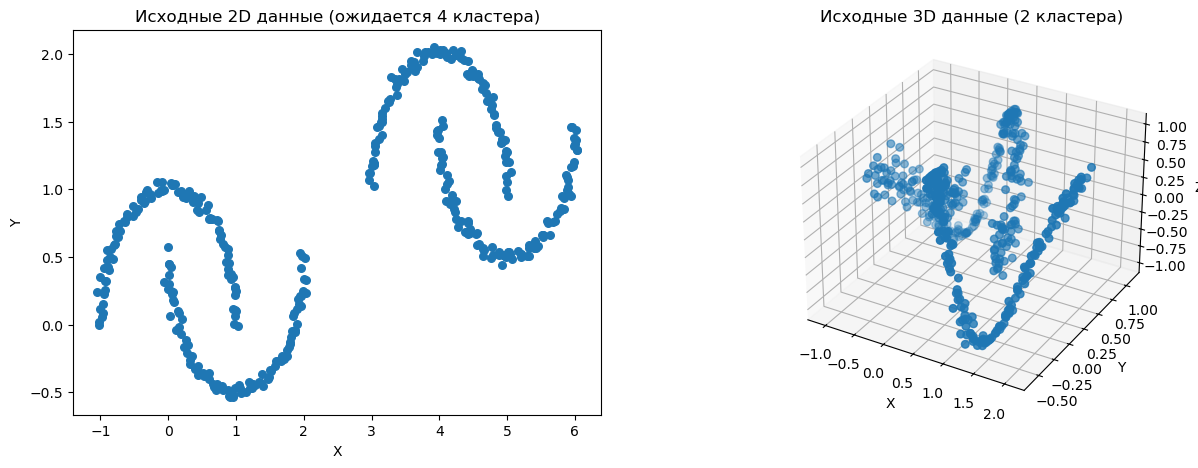


Подбор параметров DBSCAN для 2D данных по методу силуэта:
Лучшие параметры (eps, min_samples): (0.15, 3) (силуэт: 0.33)


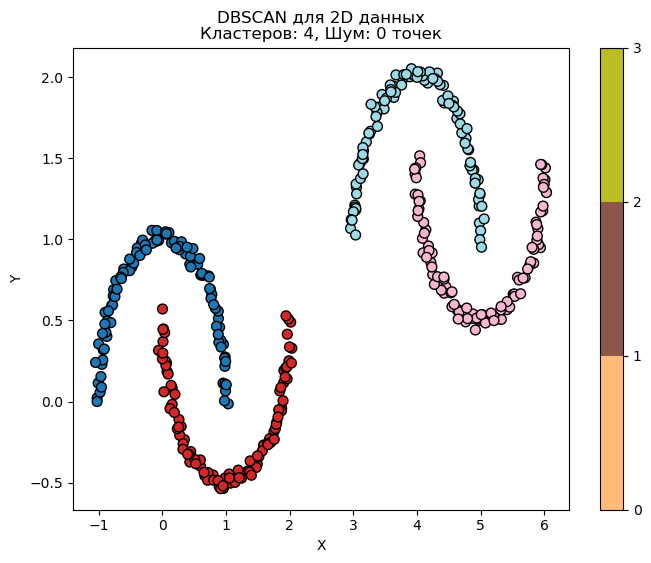

Силуэт: 0.33

Подбор параметров DBSCAN для 3D данных по методу силуэта:
Лучшие параметры (eps, min_samples): (0.3, 4) (силуэт: 0.25)


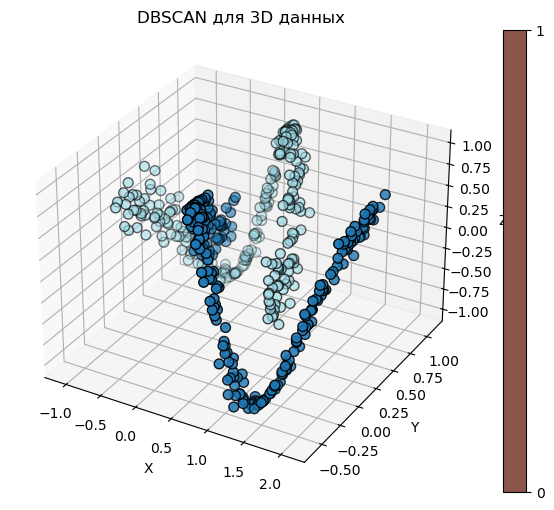

Силуэт: 0.25

Сравнение с KMeans для 2D данных:


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors


# Реализация алгоритма DBSCAN (собственная версия)
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        """
        eps: радиус eps-окрестности.
        min_samples: минимальное число точек в eps-окрестности для формирования ядра.
        """
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        n_samples = X.shape[0]
        visited = np.zeros(n_samples, dtype=bool)
        labels = np.full(n_samples, -1, dtype=int)  # -1 означает шум
        cluster_id = 0

        for i in range(n_samples):
            if not visited[i]:
                visited[i] = True
                neighbors = self.region_query(X, i)
                if len(neighbors) < self.min_samples:
                    labels[i] = -1  # точка не является ядром — шум
                else:
                    self.expand_cluster(X, i, neighbors, cluster_id, visited, labels)
                    cluster_id += 1
        self.labels_ = labels
        return self

    def expand_cluster(self, X, core_point_idx, neighbors, cluster_id, visited, labels):
        labels[core_point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            point_idx = neighbors[i]
            if not visited[point_idx]:
                visited[point_idx] = True
                new_neighbors = self.region_query(X, point_idx)
                if len(new_neighbors) >= self.min_samples:
                    neighbors = np.concatenate([neighbors, new_neighbors])
            if labels[point_idx] == -1:
                labels[point_idx] = cluster_id
            i += 1

    def region_query(self, X, point_idx):
        distances = euclidean_distances([X[point_idx]], X).ravel()
        return np.where(distances <= self.eps)[0]


# Генерация данных
def generate_data():
    # 2D данные: 4 кластера
    X1, y1 = make_moons(n_samples=200, noise=0.03, random_state=42)
    X2, y2 = make_moons(n_samples=200, noise=0.03, random_state=52)
    # Увеличенный сдвиг для лучшего разделения кластеров
    X2 += np.array([4.0, 1.0])
    X_2d = np.vstack([X1, X2])

    # 3D данные: 2 кластера
    X_circles, _ = make_moons(n_samples=500, noise=0.05, random_state=42)
    X_3d = np.zeros((X_circles.shape[0], 3))
    X_3d[:, :2] = X_circles
    X_3d[:, 2] = np.sin(X_circles[:, 0] * 3.5)  # нелинейное преобразование для усиления разделения
    return X_2d, X_3d


# Визуализация исходных данных
def plot_original_data(X_2d, X_3d):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], s=30)
    plt.title("Исходные 2D данные (ожидается 4 кластера)")
    plt.xlabel("X")
    plt.ylabel("Y")

    ax = plt.subplot(1, 2, 2, projection='3d')
    ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], s=30)
    ax.set_title("Исходные 3D данные (2 кластера)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    plt.show()


# Функция для визуального подбора eps (метод локтя для расстояний до k-го соседа)
def find_optimal_eps(X, k=4):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, -1])

    plt.figure(figsize=(8, 4))
    plt.plot(distances)
    plt.title(f'Метод локтя для подбора eps (k={k})')
    plt.xlabel('Номер точки')
    plt.ylabel(f'Расстояние до {k}-го соседа')
    plt.grid(True)
    plt.show()


# Функция для подбора оптимальных параметров DBSCAN по методу силуэта (grid search)
def tune_dbscan(X, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            labels = db.labels_
            mask = labels != -1  # исключаем шум
            if len(np.unique(labels[mask])) > 1:
                score = silhouette_score(X[mask], labels[mask])
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
    return best_params, best_score


# Применение DBSCAN и визуализация результатов кластеризации
def apply_dbscan(X, eps, min_samples, title):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)
    labels = dbscan.labels_

    plt.figure(figsize=(8, 6))
    if X.shape[1] == 2:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab20', s=50, edgecolors='k')
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = sum(labels == -1)
        plt.title(f'{title}\nКластеров: {n_clusters}, Шум: {n_noise} точек')
        plt.xlabel("X")
        plt.ylabel("Y")
    else:
        ax = plt.subplot(111, projection='3d')
        scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='tab20', s=50, edgecolors='k')
        ax.set_title(title)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        plt.colorbar(scatter, boundaries=unique_labels)
    else:
        plt.colorbar(scatter)
    plt.show()

    # Расчёт коэффициента силуэта (исключая шумовые точки)
    if len(unique_labels) > 1:
        mask = labels != -1
        if len(np.unique(labels[mask])) > 1:
            score = silhouette_score(X[mask], labels[mask])
            print(f'Силуэт: {score:.2f}')
            return
    print('Недостаточно кластеров для оценки силуэта')


# Функция для сравнения с KMeans (подбор оптимального k по методу локтя и силуэта)
def compare_with_kmeans(X):
    # Метод локтя для определения оптимального числа кластеров (WCSS)
    wcss = []
    max_k = 10
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k + 1), wcss, 'bo-')
    plt.title('Метод локтя для KMeans')
    plt.xlabel('Количество кластеров')
    plt.ylabel('WCSS')
    plt.show()

    # Определяем оптимальное число кластеров по коэффициенту силуэта
    best_score = -1
    best_k = 1
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k

    print(f'Оптимальное число кластеров для KMeans: {best_k} (силуэт: {best_score:.2f})')
    return best_k


# Основной блок выполнения
X_2d, X_3d = generate_data()
plot_original_data(X_2d, X_3d)

# Подбор параметров для DBSCAN с помощью метода силуэта:
print('\n' + '=' * 50)
print('Подбор параметров DBSCAN для 2D данных по методу силуэта:')
eps_values_2d = np.linspace(0.15, 0.30, 8)  # диапазон для eps
min_samples_values_2d = range(3, 6)  # диапазон для min_samples
best_params_2d, best_score_2d = tune_dbscan(X_2d, eps_values_2d, min_samples_values_2d)
print(f'Лучшие параметры (eps, min_samples): {best_params_2d} (силуэт: {best_score_2d:.2f})')
apply_dbscan(X_2d, eps=best_params_2d[0], min_samples=best_params_2d[1], title='DBSCAN для 2D данных')

print('\n' + '=' * 50)
print('Подбор параметров DBSCAN для 3D данных по методу силуэта:')
eps_values_3d = np.linspace(0.30, 0.50, 8)  # диапазон для eps
min_samples_values_3d = range(4, 7)  # диапазон для min_samples
best_params_3d, best_score_3d = tune_dbscan(X_3d, eps_values_3d, min_samples_values_3d)
print(f'Лучшие параметры (eps, min_samples): {best_params_3d} (силуэт: {best_score_3d:.2f})')
apply_dbscan(X_3d, eps=best_params_3d[0], min_samples=best_params_3d[1], title='DBSCAN для 3D данных')

print('\n' + '=' * 50)
print('Сравнение с KMeans для 2D данных:')
best_k_2d = compare_with_kmeans(X_2d)
kmeans_2d = KMeans(n_clusters=best_k_2d, random_state=42)
labels_2d = kmeans_2d.fit_predict(X_2d)
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_2d, cmap='tab20', s=50, edgecolors='k')
plt.title(f'KMeans (k={best_k_2d}) для 2D данных')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

print('\n' + '=' * 50)
print('Сравнение с KMeans для 3D данных:')
best_k_3d = compare_with_kmeans(X_3d)
kmeans_3d = KMeans(n_clusters=best_k_3d, random_state=42)
labels_3d = kmeans_3d.fit_predict(X_3d)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels_3d, cmap='tab20', s=50, edgecolors='k')
ax.set_title(f'KMeans (k={best_k_3d}) для 3D данных')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
